## Import librairies

In [129]:
import numpy as np
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt
import random
from time import sleep
from typing import Tuple, List, Dict
from functools import partial, reduce
from tqdm import tqdm

## The Problem

- Problème du sac à dos

In [130]:
from benchmark.read import list_benchmarks, read_kp_benchmark

list_benchmarks('kp')

['.DS_Store',
 '__MACOSX',
 'KP_p-3_n-100_ins-1.dat',
 'KP_p-3_n-100_ins-10.dat',
 'KP_p-3_n-100_ins-2.dat',
 'KP_p-3_n-100_ins-3.dat',
 'KP_p-3_n-100_ins-4.dat',
 'KP_p-3_n-100_ins-5.dat',
 'KP_p-3_n-100_ins-6.dat',
 'KP_p-3_n-100_ins-7.dat',
 'KP_p-3_n-100_ins-8.dat',
 'KP_p-3_n-100_ins-9.dat',
 'KP_p-3_n-10_ins-1.dat',
 'KP_p-3_n-10_ins-10.dat',
 'KP_p-3_n-10_ins-2.dat',
 'KP_p-3_n-10_ins-3.dat',
 'KP_p-3_n-10_ins-4.dat',
 'KP_p-3_n-10_ins-5.dat',
 'KP_p-3_n-10_ins-6.dat',
 'KP_p-3_n-10_ins-7.dat',
 'KP_p-3_n-10_ins-8.dat',
 'KP_p-3_n-10_ins-9.dat',
 'KP_p-3_n-20_ins-1.dat',
 'KP_p-3_n-20_ins-10.dat',
 'KP_p-3_n-20_ins-2.dat',
 'KP_p-3_n-20_ins-3.dat',
 'KP_p-3_n-20_ins-4.dat',
 'KP_p-3_n-20_ins-5.dat',
 'KP_p-3_n-20_ins-6.dat',
 'KP_p-3_n-20_ins-7.dat',
 'KP_p-3_n-20_ins-8.dat',
 'KP_p-3_n-20_ins-9.dat',
 'KP_p-3_n-30_ins-1.dat',
 'KP_p-3_n-30_ins-10.dat',
 'KP_p-3_n-30_ins-2.dat',
 'KP_p-3_n-30_ins-3.dat',
 'KP_p-3_n-30_ins-4.dat',
 'KP_p-3_n-30_ins-5.dat',
 'KP_p-3_n-30_ins-6.dat

### Params

In [131]:
kp_params_dict = read_kp_benchmark(p=3, n=20, instance=5)

N_OBJECTIVE_FUNCTIONS: int = kp_params_dict["n_objective_functions"]
N_OBJECTS: int = kp_params_dict["n_objects"]
MAX_WEIGHT_CONSTRAINT: int = kp_params_dict["max_weight_constraint"]
PROFITS_MATRIX: np.ndarray = kp_params_dict["profits_matrix"]
OBJECTS_WEIGHTS: np.ndarray = kp_params_dict["objects_weights"]

Number of objective functions (p) : 3
Number of objects (n) : 20
Capacity of the knapsack (W) : 5905
Profits of the objects in each objective function : [[316 285 241 485 376  54 571 971 516 430 409 151 587 632 614 412 108 872
  265 622]
 [671 359 209 535 385 845 884 462 651 773 497 967  58 737 451 434 791  21
  404 307]
 [451 812 457  37 443  71 448 551 942 713 172 613  71 380 147 455 225  31
  917 875]]
Weights of the objects (w) [803 413 842 860 150 292 294 941 312 697 247 762 508 703 799 951 773 247
 501 715]


## Operators

### Individuals

one hot encoding

In [132]:
def init_individual(size: int):
    return np.random.choice([0.0, 1.0], size=(size,))


test_ind = init_individual(N_OBJECTS)
print(test_ind)

test_ind.nonzero()

[1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.]


(array([ 0,  5,  7, 10, 11, 12, 13, 17, 18], dtype=int64),)

In [133]:
def init_population(size: int, individual_size: int):
    return np.array([init_individual(individual_size) for _ in range(size)])


### Fitness (energie)
Calcul de la somme des profits des objets selectionnes, la somme du sac (l'energie du systeme)
Rappelons que le but ici est de maximiser la somme du sac (minimiser l'energie dépensé)

In [134]:
def fitness_objectives(individual: np.ndarray, profits_matrix: np.ndarray) -> np.ndarray:
    """
    Calcule les valeurs de fitness pour chaque objectif d'un individu pour le problème du knapsack multi-objectif.

    :param individu: un tableau numpy de 0 et 1 représentant les objets sélectionnés pour le sac à dos.
    :param profits_matrix: un tableau numpy de dimensions (p, n) représentant les profits de chaque objet pour chaque objectif.
    :return: un tableau numpy de dimensions (p,) représentant les valeurs de fitness pour chaque objectif.
    """
    # Calcule la valeur de fitness pour chaque objectif
    fitness_values = np.sum(profits_matrix * individual, axis=1)  #todo : t'es sure ? demande au prof

    # change all zero to 1e-100
    fitness_values[fitness_values == 0] = 1e-100
    return fitness_values


def fitness(individual: np.ndarray, profits_matrix: np.ndarray) -> float:
    """
    Calcule la valeur de fitness d'un individu pour le problème du knapsack multi-objectif.

    :param individu: un tableau numpy de 0 et 1 représentant les objets sélectionnés pour le sac à dos.
    :param profits_matrix: un tableau numpy de dimensions (p, n) représentant les profits de chaque objet pour chaque objectif.
    :return: un float représentant la valeur de fitness.
    """
    # Calcule la valeur de fitness pour chaque objectif
    fitness_values = fitness_objectives(individual, profits_matrix)
    # Calcule la valeur de fitness totale : sum(ln(fitness_values))

    return np.sum(np.log(fitness_values)) #todo : add fmin poids des objets


print(test_ind)
print(fitness(test_ind, PROFITS_MATRIX))
fitness_objectives(test_ind, PROFITS_MATRIX)

[1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.]
24.892081590700087


array([4257., 4662., 3257.])

In [135]:
fitness_objectives(np.zeros(N_OBJECTS), PROFITS_MATRIX)

array([1.e-100, 1.e-100, 1.e-100])

### Faisability & Repare

In [136]:
def faisability(individual: np.ndarray, objects_weights: np.ndarray, capacity_constraint: int) -> Tuple[bool, int]:
    """
    Calcule la faisabilité d'un individu pour le problème du knapsack multi-objectif.
    """

    sum_knapsack_weights = np.sum(individual * objects_weights)
    if sum_knapsack_weights > capacity_constraint:
        return False, sum_knapsack_weights
    return True, sum_knapsack_weights


print(MAX_WEIGHT_CONSTRAINT)
faisability(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT)

5905


(True, 5004.0)

Au début j'avais fait une fonction de réparation paramétrable de façon à retirer à chaque fois l'objet le plus lourd du sac, mais "# LAISSER JUSTE ALEA PARC QUE SINON TU VA TOUJOURS ENLEVER LE PLUS GRAND JCROIS" c'est pas très efficace, car ça peut retirer un objet qui a un profit élevé, et ça peut retirer un objet qui a un profit élevé pour un objectif, mais pas pour un autre. Donc juste gardé la fonction de réparation qui retire un objet au hasard du sac, tant que le sac n'est pas faisable.

In [137]:
def repare(individual, objects_weights, capacity_constraint):
    individual = individual.copy()
    if indexes := list(individual.nonzero()[0]):
        while not faisability(individual, objects_weights, capacity_constraint)[0]:
            # choisir un élement du sac
            index = random.choice(indexes)
            # le retirer du sac
            individual[index] = 0
            # le retirer de la liste des index
            indexes.remove(index)
    #else:
    #    individual[random.randint(0, len(individual) - 1)] = 1
    return individual  # mm si ça marche sans retourner


test_ind = init_individual(N_OBJECTS)
print(test_ind, faisability(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT))
test_ind = repare(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT)
print(test_ind, faisability(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT))

[1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] (True, 5489.0)
[1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] (True, 5489.0)


### Visualize population

In [138]:
def print_individual(individual: np.ndarray, profits_matrix: np.ndarray, objects_weights: np.ndarray, full_print_individual : bool = False, full_print_profits : bool = False) -> None:
    """
    Print the individual and its fitness.
    """

    if len(individual) <= 10 or full_print_individual:
        str_individual = f"{individual}, fit={fitness(individual, profits_matrix):>4.2f}"
    else:
        str_individual = f"{individual[:8]}...{individual[-2:]}, fit={fitness(individual, profits_matrix):>4.2f}"
    profits = fitness_objectives(individual, profits_matrix)
    if len(profits) <= 5 or full_print_profits:
        str_profits = f", profits={str(profits):>19}"
    else:
        str_profits = f", profits={str(profits[:3])}...{str(profits[-2:]):>19}"

    str_total_weight = f", weight={np.sum(individual * objects_weights):>5.0f}"

    print(str_individual + str_profits + str_total_weight)


print_individual(test_ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print_individual(np.ones(N_OBJECTS), PROFITS_MATRIX, OBJECTS_WEIGHTS)

for _ in range(10):
    print_individual(init_individual(N_OBJECTS), PROFITS_MATRIX, OBJECTS_WEIGHTS)


[1. 0. 1. 0. 1. 1. 1. 1.]...[1. 1.], fit=25.13, profits=[3828. 4601. 4668.], weight= 5489
[1. 1. 1. 1. 1. 1. 1. 1.]...[1. 1.], fit=27.43, profits=[ 8917. 10441.  8811.], weight=11810
[1. 1. 0. 0. 1. 0. 1. 1.]...[1. 0.], fit=25.99, profits=[5106. 6468. 5876.], weight= 5925
[0. 1. 0. 0. 1. 1. 1. 1.]...[0. 0.], fit=24.80, profits=[3290. 4874. 3664.], weight= 3422
[0. 0. 1. 0. 1. 1. 0. 1.]...[1. 0.], fit=25.35, profits=[5016. 4711. 4310.], weight= 6316
[0. 1. 1. 0. 0. 1. 0. 1.]...[0. 1.], fit=24.77, profits=[4878. 3449. 3395.], weight= 5460
[0. 0. 1. 1. 1. 1. 0. 0.]...[0. 1.], fit=25.67, profits=[5537. 5763. 4392.], weight= 6898
[0. 1. 1. 1. 1. 0. 1. 1.]...[1. 0.], fit=25.38, profits=[4548. 5217. 4417.], weight= 6276
[1. 0. 1. 1. 0. 0. 0. 1.]...[1. 0.], fit=25.52, profits=[4373. 5730. 4845.], weight= 6679
[0. 1. 1. 1. 0. 1. 1. 1.]...[1. 0.], fit=24.84, profits=[4153. 4216. 3496.], weight= 4637
[1. 1. 1. 1. 1. 0. 1. 0.]...[0. 0.], fit=25.48, profits=[4526. 5777. 4438.], weight= 5905
[1. 0. 

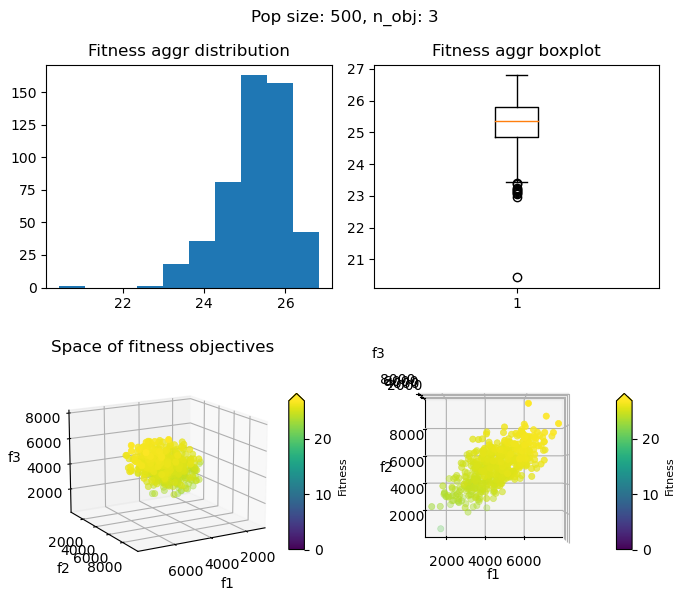

In [139]:
def visualize_population(population: List[np.ndarray], profits_matrix: np.ndarray) -> None:
    """
    Visualize a population of individuals in fitness space.
    """

    dim = profits_matrix.shape[0]
    display_second_plot = 2 <= dim <= 3

    fig = plt.figure(figsize=(7, 4 if not display_second_plot else 6))
    fig.suptitle("Pop size: " + str(len(population)) + ", n_obj: " + str(profits_matrix.shape[0]))

    # Fitness distribution
    ax = fig.add_subplot(2 if display_second_plot else 1, 2, 1)
    fitnesses_agg = [fitness(ind, profits_matrix) for ind in population]
    ax.hist(fitnesses_agg)
    ax.set_title("Fitness aggr distribution")

    # Fitness boxplot
    ax = fig.add_subplot(2 if display_second_plot else 1, 2, 2)
    ax.boxplot(fitnesses_agg)
    ax.set_title("Fitness aggr boxplot")

    # 3D Viz of fitness
    if display_second_plot:
        if dim == 3:
            fitness_objectives_values = [fitness_objectives(ind, profits_matrix) for ind in population]
            f1, f2, f3 = zip(*fitness_objectives_values)

            ax = fig.add_subplot(2, 2, 3, projection='3d')
            ax.view_init(15, 60)
            scatter = ax.scatter(f1, f2, f3, c=fitnesses_agg, cmap='viridis', linewidth=0.5)
            ax.set_title("Space of fitness objectives")
            ax.set_xlabel("f1")
            ax.set_ylabel("f2")
            ax.set_zlabel("f3")
            # add color bar (min value is 0)
            cbar = fig.colorbar(scatter, shrink=0.7, aspect=10, extend='max')
            cbar.ax.set_ylabel('Fitness', fontsize=8)
            scatter.set_clim(vmin=0)


            ax = fig.add_subplot(2, 2, 4, projection='3d')
            ax.view_init(90, 90 * 3)
            scatter = ax.scatter(f1, f2, f3, c=fitnesses_agg, cmap='viridis', linewidth=0.5)
            #ax.set_title("Space of fitness objectives")
            ax.set_xlabel("f1")
            ax.set_ylabel("f2")
            ax.set_zlabel("f3")
            # add color bar (min value is 0)
            cbar = fig.colorbar(scatter, shrink=0.7, aspect=10, extend='max')
            cbar.ax.set_ylabel('Fitness', fontsize=8)

            scatter.set_clim(vmin=0)

        elif dim == 2:
            fitness_objectives_values = [fitness_objectives(ind, profits_matrix) for ind in population]

            f1, f2 = zip(*fitness_objectives_values)

            ax = fig.add_subplot(2, 2, 3)
            scatter = ax.scatter(f1, f2, c=fitnesses_agg, cmap='viridis', linewidth=0.5)
            ax.set_title("Space of fitness objectives")
            ax.set_xlabel("f1")
            ax.set_ylabel("f2")

            ax = fig.add_subplot(2, 2, 4)
            scatter = ax.scatter(f1, f2, c=fitnesses_agg, cmap='viridis', linewidth=0.5)
            #ax.set_title("Space of fitness objectives")
            ax.set_xlabel("f1")
            ax.set_ylabel("f2")

            # add color bar
            fig.colorbar(scatter, ax=ax, shrink=0.7, aspect=10, label="Fitness aggregate (energy)")

    fig.tight_layout(h_pad=2.5)
    plt.show()


test_pop = init_population(500, N_OBJECTS)
visualize_population(test_pop, PROFITS_MATRIX)

### Compare

#### Diversity

In [140]:
def count_diff(x1: np.ndarray, x2: np.ndarray) -> int:
    """
    Return the number of differences between x1 and x2.
    """
    if len(x1) != len(x2):
        raise ValueError("x1 and x2 must have the same length")
    return np.sum(x1 != x2)

def percent_diff(x1: np.ndarray, x2: np.ndarray) -> float:
    """
    Return the percentage of differences between x1 and x2.
    """
    return count_diff(x1, x2) / len(x1)


def diversity(population: List[np.ndarray]) -> float:
    """
    Return the average number of differences between individuals in the population.
    """
    n = len(population)
    return np.sum([count_diff(population[i], population[j]) for i in range(n) for j in range(i + 1, n)]) / (n * (n - 1) / 2)

def percent_diversity(population: List[np.ndarray]) -> float:
    """
    Return the average percentage of differences between individuals in the population.
    """
    n = len(population)
    return np.sum([percent_diff(population[i], population[j]) for i in range(n) for j in range(i + 1, n)]) / (n * (n - 1) / 2)

pop_test = [init_individual(N_OBJECTS) for _ in range(1000)]
print("Diversity: ", diversity(pop_test))
print("Percent diversity: ", percent_diversity(pop_test))

Diversity:  9.999973973973974
Percent diversity:  0.49999869869869873


#### Best individual

In [141]:
def is_better(x1: np.ndarray, x2: np.ndarray, profits_matrix: np.ndarray) -> bool:
    """
    Return True if x1 is better than x2, and delta is the difference between the two fitness values.
    """
    fitness_x1 = fitness(x1, profits_matrix)
    fitness_x2 = fitness(x2, profits_matrix)
    return fitness_x1 > fitness_x2


def max_individual(x1: np.ndarray, x2: np.ndarray, profits_matrix: np.ndarray) -> np.ndarray:
    """
    Return the best individual between x1 and x2.
    """
    return x1 if is_better(x1, x2, profits_matrix) else x2


x1 = init_individual(N_OBJECTS)
x2 = init_individual(N_OBJECTS)
print_individual(x1, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print_individual(x2, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print(is_better(x1, x2, PROFITS_MATRIX))



[1. 0. 1. 0. 0. 0. 0. 0.]...[0. 1.], fit=23.75, profits=[2976. 2356. 2928.], weight= 3166
[1. 1. 1. 1. 1. 0. 0. 1.]...[0. 1.], fit=26.47, profits=[6897. 7206. 6286.], weight= 9612
False


In [142]:
z = np.zeros(N_OBJECTS)
z[0] = 1
fitness(z, PROFITS_MATRIX)

18.375978690061274

In [143]:
def get_best_individual(population: List[np.ndarray], profits_matrix: np.ndarray) -> np.ndarray:
    """
    Return the best individual in the population.
    """
    return reduce(partial(max_individual, profits_matrix=profits_matrix), population)


def get_best_individuals(population: List[np.ndarray], profits_matrix: np.ndarray, n_best: int) -> List[np.ndarray]:
    """
    Return the n best individuals in the population.
    """
    return sorted(population, key=partial(fitness, profits_matrix=profits_matrix), reverse=True)[:n_best]


test_pop = init_population(10, N_OBJECTS)
for ind in test_pop:
    print(ind, fitness(ind, PROFITS_MATRIX))

print("---")
best_ind_test = get_best_individual(test_pop, PROFITS_MATRIX)
print("best", best_ind_test, fitness(best_ind_test, PROFITS_MATRIX))
print("bests 3")
for ind in get_best_individuals(test_pop, PROFITS_MATRIX, 3):
    print(ind, fitness(ind, PROFITS_MATRIX))

[0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.] 25.69001345541215
[0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.] 23.73136907361437
[0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.] 23.86857386997723
[1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1.] 25.603071588142235
[0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1.] 25.426883931913927
[1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 25.063868430281214
[0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.] 24.66145765666724
[1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.] 24.921738856874548
[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.] 24.366856711130513
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0.] 24.40215108140952
---
best [0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.] 25.69001345541215
bests 3
[0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.] 25.69001345541215
[1. 0. 0. 1. 0. 1.

#### Dominance

In [144]:
def dominance_compare(x1: np.ndarray, x2: np.ndarray, profits_matrix: np.ndarray) -> bool:
    """
    Return 1 if x1 dominates x2, -1 if x2 dominates x1, and 0 if x1 and x2 are non-dominated.
    """
    fitness_x1: np.ndarray = fitness_objectives(x1, profits_matrix)
    fitness_x2: np.ndarray = fitness_objectives(x2, profits_matrix)

    #print(fitness_x1 >= fitness_x2)
    #print(fitness_x1 > fitness_x2)
    #print(all(fitness_x1 >= fitness_x2))
    #print(any(fitness_x1 > fitness_x2))

    if all(fitness_x1 >= fitness_x2) and any(fitness_x1 > fitness_x2):
        return 1
    elif all(fitness_x1 <= fitness_x2) and any(fitness_x1 < fitness_x2):
        return -1
    return 0


x1 = init_individual(N_OBJECTS)
x2 = init_individual(N_OBJECTS)
print_individual(x1, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print_individual(x2, PROFITS_MATRIX, OBJECTS_WEIGHTS)

dominance_compare(x1, x2, PROFITS_MATRIX)

[1. 0. 0. 0. 1. 0. 1. 0.]...[0. 0.], fit=23.16, profits=[1783. 3165. 2022.], weight= 2971
[1. 0. 1. 1. 1. 0. 0. 0.]...[1. 1.], fit=25.54, profits=[5325. 5102. 4539.], weight= 7142


-1

In [145]:
dominance_compare(x1, np.zeros(N_OBJECTS), PROFITS_MATRIX)

1

#### Archive

In [146]:
archive_test = [init_individual(N_OBJECTS) for _ in range(100)]
for ind in archive_test:
    print_individual(ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)

print("--- new ind")
new_ind = init_individual(N_OBJECTS)
print_individual(new_ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print("--- good ind")
good_ind_test = get_best_individuals([init_individual(N_OBJECTS) for _ in range(1000)], PROFITS_MATRIX, 1)[0]
print_individual(good_ind_test, PROFITS_MATRIX, OBJECTS_WEIGHTS)


[0. 0. 1. 0. 1. 1. 0. 1.]...[1. 1.], fit=25.68, profits=[5552. 5140. 4956.], weight= 7416
[0. 1. 1. 0. 0. 1. 0. 1.]...[1. 0.], fit=24.74, profits=[3551. 3725. 4201.], weight= 4512
[1. 0. 1. 0. 0. 0. 0. 1.]...[0. 0.], fit=25.20, profits=[3756. 5472. 4271.], weight= 6176
[0. 1. 0. 1. 1. 0. 1. 1.]...[0. 1.], fit=25.38, profits=[4505. 5070. 4614.], weight= 5789
[0. 0. 1. 1. 1. 1. 1. 1.]...[0. 0.], fit=25.37, profits=[4790. 6324. 3443.], weight= 6924
[1. 0. 1. 0. 0. 1. 1. 0.]...[0. 0.], fit=25.54, profits=[4000. 6734. 4593.], weight= 7033
[0. 1. 1. 0. 1. 0. 1. 1.]...[1. 0.], fit=25.91, profits=[4948. 6065. 5936.], weight= 7053
[1. 0. 1. 1. 1. 0. 0. 1.]...[0. 0.], fit=24.51, profits=[3336. 4323. 3049.], weight= 5313
[1. 1. 0. 0. 1. 0. 0. 1.]...[1. 1.], fit=26.40, profits=[6435. 6229. 7254.], weight= 7703
[0. 1. 1. 1. 0. 0. 1. 1.]...[1. 1.], fit=25.06, profits=[4420. 3972. 4353.], weight= 5586
[1. 1. 0. 0. 0. 1. 0. 0.]...[1. 0.], fit=24.56, profits=[2785. 4434. 3738.], weight= 4703
[0. 0. 1. 

In [147]:
def update_archive(archive: List[np.ndarray], individual: np.ndarray, profits_matrix: np.ndarray, max_size: int) -> \
        List[np.ndarray]:
    """
    Update the archive with the new individual.
    - if neighbor x_neighbor is dominated by one of the solution from the archive, do not store,
    - if neighbor x_neighbor is not dominated by the archive, store it and remove all solutions


    """
    #print("--- ")
    #print_individual(individual, profits_matrix)
    archive = archive.copy()
    count_n_individual_removed = 0
    dominated = False
    equal = False
    for idx, ind_archive in enumerate(archive):

        if dominance_compare(individual, ind_archive, profits_matrix) == -1:
            dominated = True
            #print(f"    dominated by ", end="")
            #print_individual(ind_archive, profits_matrix)
            break

        elif dominance_compare(individual, ind_archive, profits_matrix) == 1:
            archive.pop(idx)  # remove dominated individual in archive
            #print(f"    remove ", end="")
            #print_individual(ind_archive, profits_matrix)
            count_n_individual_removed += 1
        else:
            #print("    no dominance ", end="")
            #print_individual(ind_archive, profits_matrix)
            # verify if equal same individual
            if np.array_equal(individual, ind_archive):
                equal = True
                #print("    equal")
                break

    if not dominated and not equal:
        archive.append(individual)
    # sort archive, best first (max fitness)
    archive = sorted(archive, key=partial(fitness, profits_matrix=profits_matrix), reverse=True)
    # truncate archive
    return archive[:max_size], count_n_individual_removed


print("---")
# len archive init
print(len(archive_test))
print("---")
# len archive after update
print("--- 0000000 ind")
archive_test_updated, _ = update_archive(archive_test, np.zeros(N_OBJECTS), PROFITS_MATRIX, None)
print("len_archive_test_updated", len(archive_test_updated))

print("--- new ind")
archive_test_updated, _ = update_archive(archive_test, new_ind, PROFITS_MATRIX, None)
print("len_archive_test_updated", len(archive_test_updated))

print("--- good ind")
archive_test_updated, _ = update_archive(archive_test_updated, good_ind_test, PROFITS_MATRIX, 45)
print("len_archive_test_updated", len(archive_test_updated))

for ind in archive_test_updated:
    print_individual(ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)

---
100
---
--- 0000000 ind
len_archive_test_updated 100
--- new ind
len_archive_test_updated 100
--- good ind
len_archive_test_updated 45
[1. 1. 0. 1. 1. 0. 1. 1.]...[1. 1.], fit=27.02, profits=[7626. 8832. 8040.], weight= 9921
[1. 0. 0. 1. 1. 0. 0. 1.]...[1. 1.], fit=26.42, profits=[6662. 6798. 6555.], weight= 8441
[1. 1. 1. 0. 1. 1. 1. 0.]...[0. 1.], fit=26.34, profits=[5559. 7601. 6515.], weight= 7700
[1. 0. 0. 1. 0. 1. 1. 0.]...[1. 1.], fit=26.12, profits=[5793. 7322. 5208.], weight= 7569
[0. 1. 0. 1. 1. 1. 1. 1.]...[1. 1.], fit=26.02, profits=[5898. 6357. 5325.], weight= 6677
[1. 0. 0. 0. 1. 1. 1. 0.]...[0. 0.], fit=25.97, profits=[5353. 7316. 4866.], weight= 6257
[1. 1. 1. 0. 1. 0. 0. 1.]...[1. 0.], fit=25.92, profits=[5127. 5805. 6044.], weight= 7494
[0. 1. 1. 0. 1. 0. 0. 1.]...[0. 0.], fit=25.85, profits=[6044. 5331. 5227.], weight= 7336
[0. 0. 1. 0. 1. 1. 0. 1.]...[0. 1.], fit=25.83, profits=[5843. 5573. 5061.], weight= 6670
[0. 1. 1. 1. 1. 0. 0. 1.]...[1. 0.], fit=25.80, pro

In [148]:
# function to verify if all individuals in the archive are non-dominated
def verify_archive(archive: List[np.ndarray], profits_matrix: np.ndarray) -> bool:
    """
    Verify if all individuals in the archive are non-dominated.
    """

    if len(archive) == 0:
        return True

    for idx, ind1 in enumerate(archive):
        for ind2 in archive[idx + 1:]:
            if dominance_compare(ind1, ind2, profits_matrix) != 0:
                return False, (ind1, ind2)
    return True, None

def keep_non_dominated(archive: List[np.ndarray], profits_matrix: np.ndarray) -> List[np.ndarray]:
    """
    Keep only non-dominated individuals in the archive.
    """

    archive = archive.copy()
    # sort archive for eject in first the worst individuals
    archive = sorted(archive, key=partial(fitness, profits_matrix=profits_matrix))
    idx_1 = 0
    while idx_1 < len(archive):
        idx_2 = idx_1 + 1
        while idx_2 < len(archive):
            if dominance_compare(archive[idx_1], archive[idx_2], profits_matrix) == -1:
                archive.pop(idx_2)
            elif dominance_compare(archive[idx_1], archive[idx_2], profits_matrix) == 1:
                archive.pop(idx_1)
                idx_1 -= 1
                break
            else:
                idx_2 += 1

        idx_1 += 1
    return archive



archive_test = []
while len(archive_test) < 10:
    archive_test, _ = update_archive(archive_test, repare(init_individual(N_OBJECTS), objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT), PROFITS_MATRIX, None)

print("len_archive_test", len(archive_test))
ok, inds = verify_archive(archive_test, PROFITS_MATRIX)
print(f"verify_archive: {ok}")
if inds:
    print_individual(inds[0], PROFITS_MATRIX, OBJECTS_WEIGHTS)
    print_individual(inds[1], PROFITS_MATRIX, OBJECTS_WEIGHTS)


archive_test_cleaned = keep_non_dominated(archive_test, PROFITS_MATRIX)
print("archive_test_cleaned", len(archive_test_cleaned))
ok, inds = verify_archive(archive_test_cleaned, PROFITS_MATRIX)
print(f"verify_archive: {ok}")
if inds is not None:
    print_individual(inds[0], PROFITS_MATRIX, OBJECTS_WEIGHTS)
    print_individual(inds[1], PROFITS_MATRIX, OBJECTS_WEIGHTS)
if ok:
    print("archive_test_cleaned")
    for ind in archive_test_cleaned:
        print_individual(ind, PROFITS_MATRIX, OBJECTS_WEIGHTS)


len_archive_test 10
verify_archive: True
archive_test_cleaned 10
verify_archive: True
archive_test_cleaned
[1. 1. 0. 0. 0. 0. 1. 0.]...[1. 1.], fit=25.49, profits=[4028. 5037. 5802.], weight= 4744
[1. 0. 1. 0. 1. 0. 0. 0.]...[1. 1.], fit=25.49, profits=[4378. 4949. 5434.], weight= 5743
[1. 0. 0. 0. 0. 0. 1. 1.]...[1. 1.], fit=25.52, profits=[4208. 5440. 5294.], weight= 5283
[0. 1. 1. 0. 1. 0. 1. 0.]...[0. 1.], fit=25.54, profits=[3709. 5823. 5700.], weight= 5205
[0. 1. 0. 1. 1. 1. 1. 1.]...[1. 0.], fit=25.58, profits=[5332. 5563. 4317.], weight= 5599
[0. 1. 0. 1. 1. 1. 1. 0.]...[0. 0.], fit=25.61, profits=[3999. 7138. 4623.], weight= 5599
[0. 0. 1. 0. 1. 1. 1. 1.]...[0. 0.], fit=25.69, profits=[5180. 6255. 4433.], weight= 5498
[0. 1. 0. 0. 0. 0. 1. 1.]...[1. 1.], fit=25.70, profits=[5757. 4773. 5275.], weight= 5172
[1. 0. 0. 1. 1. 0. 1. 1.]...[0. 1.], fit=25.76, profits=[5310. 5656. 5104.], weight= 5781
[0. 0. 0. 0. 1. 1. 1. 0.]...[1. 1.], fit=25.81, profits=[4943. 6244. 5263.], weight

### Perturbation

In [149]:
# fonction de fluctuation autour de l'etat "thermique" du systeme : echange de 2 points dans le pb du voyageur
# perturbation "minimum"
def perturbation(individual):
    individual = individual.copy()
    n = len(individual)
    i = np.random.randint(n)
    individual[i] = 0 if individual[i] else 1
    return individual


test_ind = init_individual(N_OBJECTS)
print(test_ind, faisability(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT))
test_ind = repare(perturbation(test_ind), objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT)
print(test_ind, faisability(test_ind, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT))

[0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.] (False, 6745.0)
[0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.] (True, 5280.0)


### Critère de Metropolis

In [150]:
def critere_metropolis(x_neighbor: np.ndarray, x: np.ndarray, fct_energie, T: float) -> bool:
    """
    Calcule le critère de Metropolis pour le problème du knapsack multi-objectif.

    Args:
        x: l'individu courant
        x_neighbor: l'individu voisin
        fct_energie: la fonction d'énergie
        T: la température

    Returns:
        True si la fluctuation est améliorante, False sinon.
        True si la fluctuation est acceptée, False sinon.

    """
    # Calcule la valeur de fitness pour chaque individu
    delta_f = fct_energie(x_neighbor) - fct_energie(
        x)  # if x_neighbor is better than x, delta_f is positive (maximization problem)
    # Calcule le critère de Metropolis
    if delta_f > 0:
        return True, True
    else:
        return False, random.random() < np.exp(delta_f / T)

[0. 0. 1. 0. 1. 0. 0. 1.]...[1. 1.], fit=24.50, profits=[3317. 2974. 4411.], weight= 4797
[0. 0. 0. 0. 0. 0. 0. 0.]...[0. 0.], fit=-690.78, profits=[1.e-100 1.e-100 1.e-100], weight=    0
False


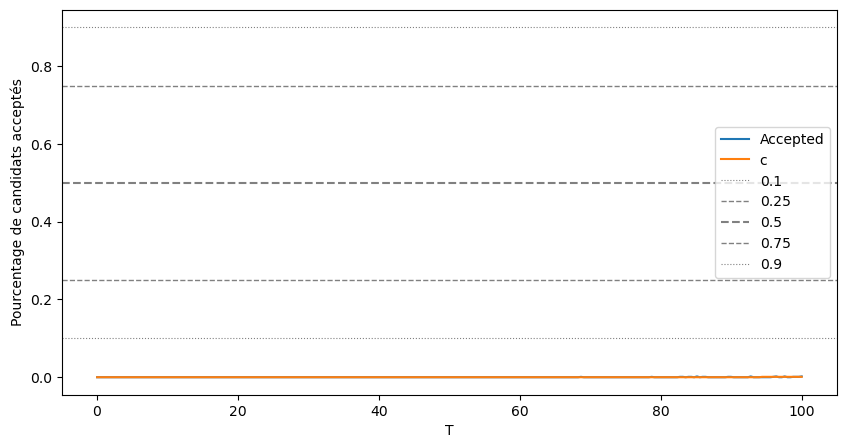

In [151]:

def critere_metropolis_test(x_neighbor: np.ndarray, x: np.ndarray, fct_energie, T: float) -> bool:
    """
    Calcule le critère de Metropolis pour le problème du knapsack multi-objectif.

    Args:
        x: l'individu courant
        x_neighbor: l'individu voisin
        fct_energie: la fonction d'énergie
        T: la température

    Returns:
        True si la fluctuation est améliorante, False sinon.
        True si la fluctuation est acceptée, False sinon.

    """
    # Calcule la valeur de fitness pour chaque individu
    delta_f = fct_energie(x_neighbor) - fct_energie(
        x)  # if x_neighbor is better than x, delta_f is positive (maximization problem)
    # Calcule le critère de Metropolis
    if delta_f > 0:
        return True, True, 1.0
    else:
        c = np.exp(delta_f / T)
        return False, random.random() < c, c


x0 = init_individual(N_OBJECTS)
x1 = init_individual(N_OBJECTS)
# get no feasible solution
while is_better(x1, x0, PROFITS_MATRIX):
    x1 = init_individual(N_OBJECTS)

x1 = np.zeros(N_OBJECTS)

print_individual(x0, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print_individual(x1, PROFITS_MATRIX, OBJECTS_WEIGHTS)
print(is_better(x1, x0, PROFITS_MATRIX))

t_values = np.linspace(0.05, 100, 250)
percentages_accepted = []
c_means = []
for t_value in t_values:
    result_metropolis = [
        critere_metropolis_test(x_neighbor=x1, x=x0, fct_energie=partial(fitness, profits_matrix=PROFITS_MATRIX),
                                T=t_value) for _ in
        range(1000)]
    # extract with zip
    _, fluctuation_accepted, c = zip(*result_metropolis)

    percentages_accepted.append(np.mean(fluctuation_accepted))
    c_means.append(np.mean(c))

# round percentages
percentages_accepted = np.round(percentages_accepted, 3)
c_means = np.round(c_means, 3)

plt.figure(figsize=(10, 5))
plt.plot(t_values, percentages_accepted, label="Accepted")
#plt.plot(t_values, percentages_improving, label="Improving")
plt.plot(t_values, c_means, label="c")

# plot a axe at 0.5
plt.axhline(0.1, color="grey", linestyle=":", label="0.1", linewidth=0.8, )
plt.axhline(0.25, color="grey", linestyle="--", label="0.25", linewidth=1, )
plt.axhline(0.5, color="grey", linestyle="--", label="0.5", )
plt.axhline(0.75, color="grey", linestyle="--", label="0.75", linewidth=1, )
plt.axhline(0.9, color="grey", linestyle=":", label="0.9", linewidth=0.8, )

plt.xlabel("T")
plt.ylabel("Pourcentage de candidats acceptés")
plt.legend()
plt.show()

In [152]:
print("Min c: ", np.min(c_means))
print(" T corresponding: ", t_values[np.argmin(c_means)])
print("Max c: ", np.max(c_means))
print(" T corresponding: ", t_values[np.argmax(c_means)])

Min c:  0.0
 T corresponding:  0.05
Max c:  0.001
 T corresponding:  94.38032128514057


In [153]:
# get the index of the first value of T when percentage_accepted > 0.1
print(f"* T = {t_values[np.argmax(percentages_accepted > 0.1)]:.2f} when percentage_accepted -> 10%")
print(f"* T = {t_values[np.argmax(percentages_accepted > 0.25)]:.2f} when percentage_accepted -> 25%")
print(f"* T = {t_values[np.argmax(percentages_accepted > 0.5)]:.2f} when percentage_accepted -> 50%")
print(f"* T = {t_values[np.argmax(percentages_accepted > 0.75)]:.2f} when percentage_accepted -> 75%")
print()
print(f"* T = {t_values[np.argmax(percentages_accepted > 0.9)]:.2f} when percentage_accepted -> 90%")
print(f"* T = {t_values[np.argmax(percentages_accepted > 0.95)]:.2f} when percentage_accepted -> 95%")

* T = 0.05 when percentage_accepted -> 10%
* T = 0.05 when percentage_accepted -> 25%
* T = 0.05 when percentage_accepted -> 50%
* T = 0.05 when percentage_accepted -> 75%

* T = 0.05 when percentage_accepted -> 90%
* T = 0.05 when percentage_accepted -> 95%


Avec ça on a maintenant une idée de :
- la valeur de T à choisir à l'initialisation de l'algorithme
- comment choisir la fonction de refroidissement

### Fonction de refroidissement

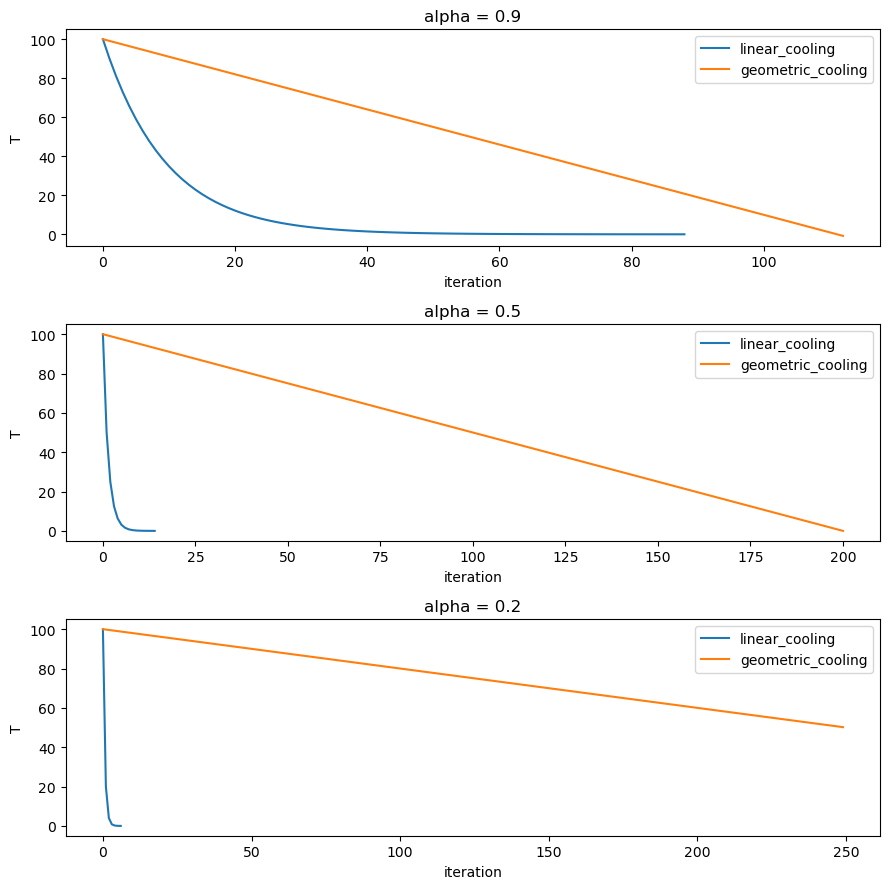

In [154]:
def constant_cooling(t):
    return t


def linear_cooling(t, alpha):
    return t * alpha


def geometric_cooling(t, alpha):
    return t - alpha


def plot_cooling_functions(alphas=[0.25], initial_temperature=20, Tmin=1e-2, limit_iter=200, list_cooling_functions=[]):
    fig, axs = plt.subplots(len(alphas), 1, figsize=(9, 3 * len(alphas)))
    t = initial_temperature

    for ax, alpha in zip(axs, alphas):
        for cooling_function in list_cooling_functions:
            t_values = [t]
            while t > Tmin and len(t_values) < limit_iter:
                t = cooling_function(t, alpha)
                t_values.append(t)
                #print(t)
            ax.plot(t_values, label=cooling_function.__name__)
            t = initial_temperature

        ax.set_title(f"alpha = {alpha}")
        ax.set_ylabel("T")
        ax.set_xlabel("iteration")
        ax.legend()

    fig.tight_layout()
    plt.show()


plot_cooling_functions(alphas=[0.9, 0.5, 0.2], initial_temperature=100, limit_iter=250,
                       list_cooling_functions=[linear_cooling, geometric_cooling])

## PASA Algorithm
Pareto Archive Simulated Annealing
# todo : question au prof, le PASA s'est juste un SA avec une archive de pareto,c'est à dire qu'à chaque nouveau voisin créer on regarde si il domine les elems de l'archives, si oui on lajoute blabla.... à quoi sert la fonction aggregate ??
a clever Simulated Annealing (Engrand, 98)

>>> PASA_Algorithme 


100%|██████████| 1000/1000 [00:09<00:00, 106.32it/s]


>>> Displaying history


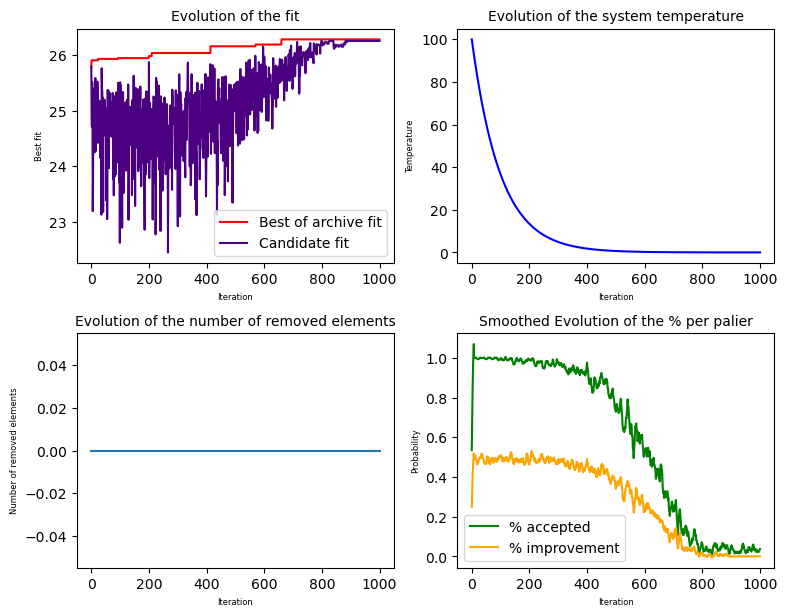

[0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.], fit=26.28, profits=[5770. 6888. 6488.], weight= 5841


In [155]:
from scipy.signal import savgol_filter


def plot_history(T_history, x_history_fit, best_x_archive_history_fit, n_archives_element_removed_history,
                 p_accept_per_palier_history, p_amelioration_per_palier_history, title=""):
    # Plot the evolution of the best fit and cohesion (subplots)

    grid = plt.GridSpec(2, 2, hspace=0.3)
    fig = plt.figure(figsize=(9, 7))
    fig.suptitle(title)

    ax1 = fig.add_subplot(grid[0, 0])
    ax1.plot(best_x_archive_history_fit, color='red', label='Best of archive fit')
    ax1.plot(x_history_fit, color='indigo', label='Candidate fit')
    ax1.set_title('Evolution of the fit', fontsize=10)
    ax1.set_xlabel('Iteration', fontsize=6)
    ax1.set_ylabel('Best fit', fontsize=6)
    ax1.legend()

    ax2 = fig.add_subplot(grid[0, 1])
    ax2.plot(T_history, color='blue')
    ax2.set_title('Evolution of the system temperature', fontsize=10)
    ax2.set_xlabel('Iteration', fontsize=6)
    ax2.set_ylabel('Temperature', fontsize=6)

    ax3 = fig.add_subplot(grid[1, 0])
    ax3.plot(n_archives_element_removed_history)
    ax3.set_title('Evolution of the number of removed elements', fontsize=10)
    ax3.set_xlabel('Iteration', fontsize=6)
    ax3.set_ylabel('Number of removed elements', fontsize=6)
    #ax3.grid(color='gray', linestyle='--', linewidth=0.5)

    ax4 = fig.add_subplot(grid[1, 1])
    ax4.plot(savgol_filter(p_accept_per_palier_history, 15, 2), color='green', label='% accepted')
    ax4.plot(savgol_filter(p_amelioration_per_palier_history, 15, 2), color='orange', label='% improvement')
    ax4.set_title('Smoothed Evolution of the % per palier', fontsize=10)
    ax4.set_xlabel('Iteration', fontsize=6)
    ax4.set_ylabel('Probability', fontsize=6)
    ax4.legend()

    plt.show()


def PASA_Algorithm_kp(kp_params_dict: dict, pop_size: int, archive_max_size: int, fitness: callable, repare: callable,
                      T0: float, Tmin: float = 1e-5,
                      cooling_method="linear",
                      cooling_rate=0.9, palier=5, max_iter=1000, display_history=True, verbose=False):
    print(">>> PASA_Algorithme ")

    N_OBJECTIVE_FUNCTIONS: int = kp_params_dict["n_objective_functions"]
    N_OBJECTS: int = kp_params_dict["n_objects"]
    MAX_WEIGHT_CONSTRAINT: int = kp_params_dict["max_weight_constraint"]
    PROFITS_MATRIX: np.ndarray = kp_params_dict["profits_matrix"]
    OBJECTS_WEIGHTS: np.ndarray = kp_params_dict["objects_weights"]

    # verify params

    assert T0 > 0, "T0 must be > 0"
    assert Tmin > 0, "Tmin must be > 0"
    assert cooling_rate > 0, "cooling_rate must be > 0"
    assert palier > 0, "palier must be > 0"
    assert max_iter > 0, "max_iter must be > 0"
    assert cooling_method in ["linear", "geometric"], "cooling_method must be in ['linear', 'geometric']"

    # init partial functions
    cooling_function = linear_cooling if cooling_method == "linear" else geometric_cooling
    cooling_function = partial(cooling_function, alpha=cooling_rate)
    fitness = partial(fitness, profits_matrix=PROFITS_MATRIX)
    repare = partial(repare, objects_weights=OBJECTS_WEIGHTS, capacity_constraint=MAX_WEIGHT_CONSTRAINT)

    if verbose:
        print(f"* archive_non_dominated_size = {archive_max_size}")
        print(f"* T0 = {T0}")
        print(f"* Tmin = {Tmin}")
        print(f"* cooling_method = {cooling_method}")
        print(f"* cooling_rate = {cooling_rate}")
        print(f"* palier = {palier}")
        print(f"* max_iter = {max_iter}")

    # initializations
    x0 = repare(init_individual(N_OBJECTS))  # initial solution
    archive_of_non_dominated = [x0]


    cpt_nb_evaluation = 0
    cpt_nb_amelioration = 0
    cpt_nb_accepted = 0
    cpt_n_archives_element_removed = 0
    # historization
    T_history = [T0]  # temperature
    x_history = [x0]  # solution
    best_x_archive_history = [x0]  # best solution in the archive
    n_archives_element_removed_history = [0]  # number of elements removed from the archive
    p_accept_per_palier_history = [0.0]  # percentage of accepted solutions
    p_amelioration_per_palier_history = [0.0]  # percentage of improved solutions
    i = 0
    T = T0
    # main loop (using tqdm for progress bar)
    pbar = tqdm(total=max_iter)
    while T > Tmin and i < max_iter:  # critere de convergence #todo : arreter si pas d'amelioration since


        cpt_nb_accepted_per_palier = 0
        cpt_nb_amelioration_per_palier = 0
        cpt_n_archives_element_removed_per_palier = 0
        for i_palier in range(palier):  # = equilibre thermodynamique
            #print(f"i = {i}, i_palier = {i_palier}", "*" * 50)
            # the fluctuation : the neighbor of x0
            x_neighbor = repare(perturbation(x0))

            # determine if the neighbor is better than x0 and if it is not dominated by the archive
            is_better_, is_accepted_by_metropolis_ = critere_metropolis(x_neighbor=x_neighbor, x=x0, T=T,
                                                                        fct_energie=fitness)

            # update x0
            if is_better_ or is_accepted_by_metropolis_:
                x0 = x_neighbor
                cpt_nb_accepted_per_palier += 1

            cpt_nb_amelioration_per_palier += int(is_better_)

            # archive update
            archive_of_non_dominated, n_archives_element_removed = update_archive(archive=archive_of_non_dominated,
                                                                                  individual=x_neighbor,
                                                                                  profits_matrix=PROFITS_MATRIX,
                                                                                  max_size=archive_max_size)

            #cpt_nb_evaluation += len(archive_of_non_dominated) # todo ?

        cpt_nb_accepted += cpt_nb_accepted_per_palier
        cpt_nb_amelioration += cpt_nb_amelioration_per_palier
        cpt_n_archives_element_removed += cpt_n_archives_element_removed_per_palier
        # Cooling (Refroidissement)
        T = cooling_function(T)

        # Historization
        T_history.append(T)
        x_history.append(x0)
        best_x_archive_history.append(archive_of_non_dominated[0])
        n_archives_element_removed_history.append(cpt_n_archives_element_removed_per_palier)
        cpt_nb_evaluation = palier * (i + 1)
        p_accept_per_palier_history.append(cpt_nb_accepted_per_palier / palier)
        p_amelioration_per_palier_history.append(cpt_nb_amelioration_per_palier / palier)

        # End of the iteration
        i += 1
        pbar.update(1)
    pbar.close()
    # end of the algorithm

    best_x_archive_at_end = archive_of_non_dominated[0]
    if verbose:
        print(">>> End of the algorithm ")
        print(f">>> Results at {T:.5f}°C after {i} iterations")
        print("> Best solution at the end :")
        print_individual(x_history[-1], PROFITS_MATRIX, OBJECTS_WEIGHTS, full_print_individual=True)
        print("> Best solution archive :")
        print_individual(best_x_archive_at_end, PROFITS_MATRIX, OBJECTS_WEIGHTS, full_print_individual=True)

        # display some stats
        print(f">> Number of evaluations : {cpt_nb_evaluation}")
        print(f">> Number of accepted neighbors : {cpt_nb_accepted}")
        print(f">> Number of improvements : {cpt_nb_amelioration}")
        print(f">> Number of archives elements removed : {cpt_n_archives_element_removed}")
    if display_history:
        print(">>> Displaying history")
        plot_history(T_history, [fitness(x) for x in x_history], [fitness(x) for x in best_x_archive_history],
                     np.array(n_archives_element_removed_history), p_accept_per_palier_history,
                     p_amelioration_per_palier_history) #todo evolution du nombre damelioration

    # print all archives
    if verbose:
        print( f">>> Archives (len={len(archive_of_non_dominated)}, verified_non_dominated={verify_archive(archive_of_non_dominated, PROFITS_MATRIX)[0]}, percent_diversity={percent_diversity(archive_of_non_dominated)}):" )
        for x in archive_of_non_dominated:
            print_individual(x, PROFITS_MATRIX, OBJECTS_WEIGHTS)
        visualize_population(archive_of_non_dominated, PROFITS_MATRIX)

    return best_x_archive_at_end, archive_of_non_dominated


solution, _ = PASA_Algorithm_kp(kp_params_dict=kp_params_dict, pop_size=100, archive_max_size=10, fitness=fitness, repare=repare,
                  T0=100, Tmin=1e-5, cooling_method="linear", cooling_rate=0.99, palier=25, max_iter=1000,
                  display_history=True, verbose=False)


print_individual(solution, PROFITS_MATRIX, OBJECTS_WEIGHTS, full_print_individual=True)

Comparer l'algo intelligent et un truc naif qui genere  10000000 individu et qui resort le meilleur le meilleur

nb d'eval dans l'algo expert, faut ça soit le mm que dans un algo naif

### Make multiple runs

In [156]:
solutions = [PASA_Algorithm_kp(kp_params_dict=kp_params_dict, pop_size=100, archive_max_size=10, fitness=fitness, repare=repare,
                      T0=100, Tmin=1e-5, cooling_method="linear", cooling_rate=0.90, palier=50, max_iter=1000,
                      display_history=False, verbose=False)[0] for _ in range(25) ]



>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:15, 54.90it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:19, 43.24it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:16, 50.96it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:13, 61.79it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:18, 46.58it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:17, 47.83it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:14, 57.85it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:18, 45.88it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:05<00:31, 27.27it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:15, 55.21it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:04<00:23, 35.52it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:15, 55.69it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:17, 48.02it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:19, 44.20it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:14, 59.81it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:15, 55.74it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:18, 44.79it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:15, 52.99it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:14, 59.61it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:19, 43.31it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:17, 47.62it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:02<00:14, 59.07it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:19, 43.40it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:16, 50.17it/s]


>>> PASA_Algorithme 


 15%|█▌        | 153/1000 [00:03<00:17, 48.34it/s]


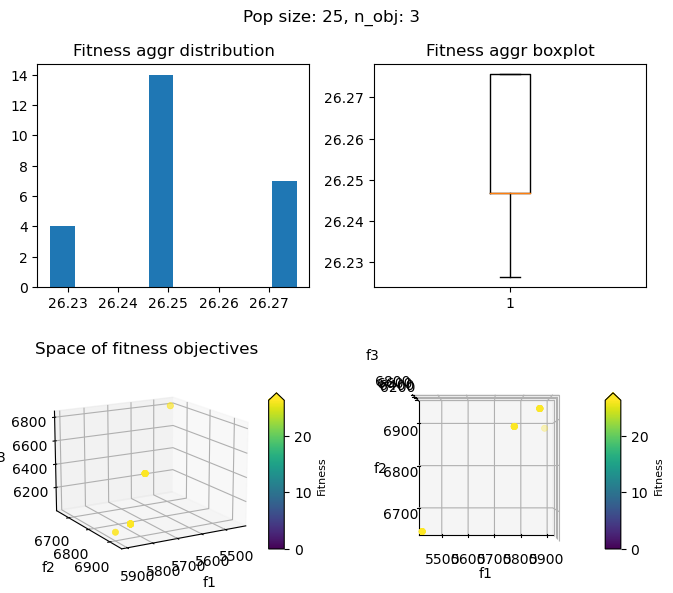

In [157]:
visualize_population(solutions, PROFITS_MATRIX)

In [158]:
diversity(solutions)

1.9533333333333334

In [159]:
percent_diversity(solutions)

0.09766666666666665

In [160]:
# get fitness and weight each solution
fitnesses, weights = zip(*[(fitness(x, profits_matrix=PROFITS_MATRIX), sum(OBJECTS_WEIGHTS * x)) for x in solutions])

fitnesses = np.array(fitnesses)
weights = np.array(weights)

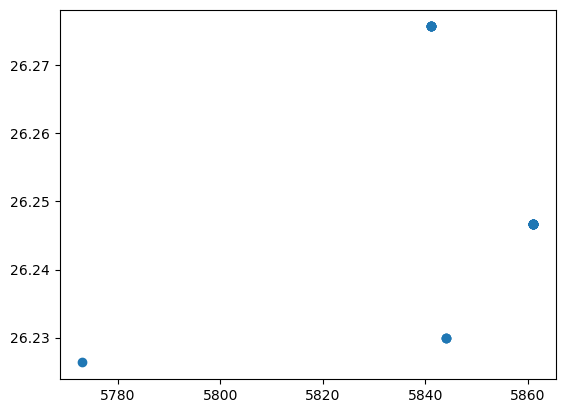

In [161]:
plt.scatter(weights, fitnesses)

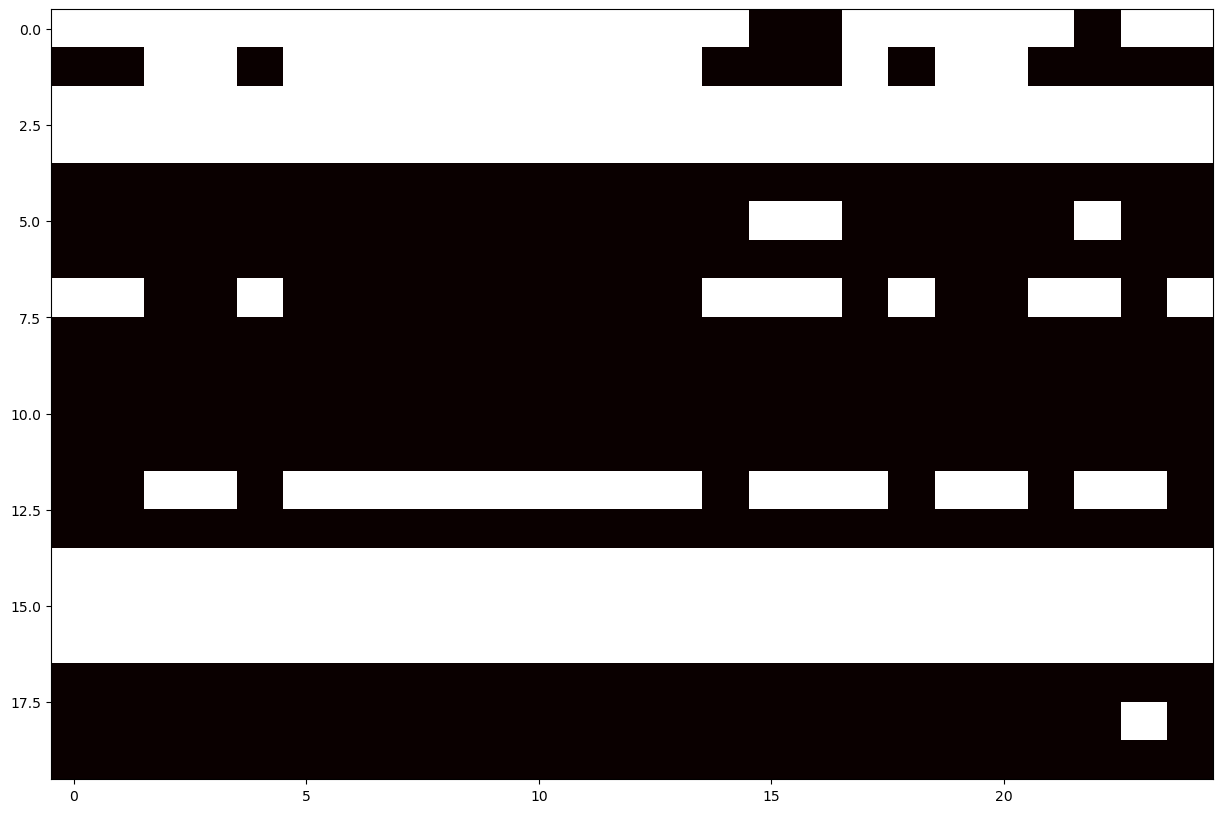

In [162]:
fig = plt.figure(figsize=(15, 10))
matrix_solutions = np.array(solutions).T
plt.imshow(matrix_solutions == 0, cmap='hot', aspect='auto')
plt.show(fig)